<a href="https://colab.research.google.com/github/guiaustregesilo-ds/Rossman_Project/blob/main/DS_em_Produ%C3%A7%C3%A3o_Oficial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

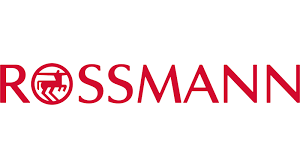

# 0.0 IMPORTS

In [132]:
import pandas            as pd
import numpy             as np

import seaborn           as sns
import matplotlib.pyplot as plt

from matplotlib.gridspec import GridSpec
from tabulate            import tabulate
from scipy               import stats as ss

from sklearn.preprocessing import RobustScaler, MinMaxScaler, LabelEncoder

import inflection
import math
import datetime

import warnings
warnings.filterwarnings("ignore")

from IPython.display     import Image

## 0.1 HELPER FUNCTIONS



In [122]:
# cramer_v

def cramer_v(x, y):
    cm = pd.crosstab(x, y).to_numpy()
    n = cm.sum()
    r, k = cm.shape

    chi2 = ss.chi2_contingency(cm)[0]
    chi2corr = max(0, chi2 - (k - 1) * (r - 1) / (n - 1) )
    kcorr = k - (k - 1) ** 2 / (n - 1)
    rcorr = r - (r - 1) ** 2 / (n - 1)

    return np.sqrt((chi2corr / n) / (min(kcorr - 1, rcorr - 1)))

## 0.2 LOADING DATA




In [3]:
df_sales_raw = pd.read_csv('/content/drive/MyDrive/DS em Produção/Datasets/train.csv', low_memory=False)
df_store_raw = pd.read_csv('/content/drive/MyDrive/DS em Produção/Datasets/store.csv', low_memory=False)

# Merge
df_raw = pd.merge(df_sales_raw, df_store_raw, how='left', on='Store')


# 1.0 DATA DESCRIPTION

In [4]:
df1 = df_raw.copy()

## 1.1 Rename Columns

In [5]:
cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo','StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval']


snakecase = lambda x: inflection.underscore(x)

cols_new = list(map(snakecase, cols_old))

# Rename
df1.columns = cols_new

## 1.2 Data Dimension

In [6]:
print('Number of Rows: {}'.format(df1.shape[0]))
print('Number of Columns: {}'.format(df1.shape[1]))

Number of Rows: 1017209
Number of Columns: 18


## 1.3 Data Types


In [7]:
# date transformation
df1['date'] = pd.to_datetime(df1['date'])

# types
df1.dtypes

,0
store,int64
day_of_week,int64
date,datetime64[ns]
sales,int64
customers,int64
open,int64
promo,int64
state_holiday,object
school_holiday,int64
store_type,object


## 1.4 Check NA's

In [8]:
df1.isna().sum()

,0
store,0
day_of_week,0
date,0
sales,0
customers,0
open,0
promo,0
state_holiday,0
school_holiday,0
store_type,0


## 1.5 Fillout NA's

In [9]:
#competition_distance
df1['competition_distance'] = df1['competition_distance'].apply(lambda x: 200000.0 if math.isnan(x) else x)

#competition_open_since_month
df1['competition_open_since_month'] = df1.apply(lambda x: x['date'].month if math.isnan(x['competition_open_since_month']) else x['competition_open_since_month'], axis=1)

# competition_open_since_year
df1['competition_open_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['competition_open_since_year']) else x['competition_open_since_year'], axis=1)

#promo2_since_week
df1['promo2_since_week'] = df1.apply(lambda x: x['date'].week if math.isnan(x['promo2_since_week']) else x['promo2_since_week'], axis=1)

#promo2_since_year
df1['promo2_since_year'] = df1.apply(lambda x: x['date'].week if math.isnan(x['promo2_since_year']) else x['promo2_since_year'], axis=1 )

#promo_interval
month_map = {1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'}

df1['promo_interval'].fillna(0, inplace=True)

df1['month_map'] = df1['date'].dt.month.map(month_map)

df1['is_promo'] = df1[['promo_interval', 'month_map']].apply(lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split(',') else 0, axis=1)

## 1.6 Change Types

In [10]:
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype(int)
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype(int)

df1['promo2_since_week'] = df1['promo2_since_week'].astype(int)
df1['promo2_since_year'] = df1['promo2_since_year'].astype(int)

## 1.7 Descriptive Statistical

In [11]:
num_attributes = df1.select_dtypes(include=['int64', 'float64'])
cat_attributes = df1.select_dtypes(exclude=['int64', 'float64', 'datetime'])

## 1.7.1 Numerical Attributes

In [12]:
# Central Tendences - mean, median
ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame(num_attributes.apply(np.median)).T

# Dispersion - std, min, max, range, skew
d1 = pd.DataFrame(num_attributes.apply(np.std)).T
d2 = pd.DataFrame(num_attributes.apply(min)).T
d3 = pd.DataFrame(num_attributes.apply(max)).T
d4 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).T
d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T

# Concatenate
m = pd.concat([d2, d3, d4, ct1, ct2, d1, d5, d6]).T.reset_index()

# Name Columns
m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,store,1.0,1115.0,1114.0,558.429727,558.0,321.908493,-0.000955,-1.200524
1,day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997390,0.001593,-1.246873
2,sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,0.641460,1.778375
3,customers,0.0,7388.0,7388.0,633.145946,609.0,464.411506,1.598650,7.091773
4,open,0.0,1.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723
5,promo,0.0,1.0,1.0,0.381515,0.0,0.485758,0.487838,-1.762018
6,school_holiday,0.0,1.0,1.0,0.178647,0.0,0.383056,1.677842,0.815154
7,competition_distance,20.0,200000.0,199980.0,5935.442677,2330.0,12547.646829,10.242344,147.789712
8,competition_open_since_month,1.0,12.0,11.0,6.786849,7.0,3.311085,-0.042076,-1.232607
9,competition_open_since_year,1900.0,2015.0,115.0,2010.324840,2012.0,5.515591,-7.235657,124.071304


<Axes: xlabel='competition_distance', ylabel='Density'>

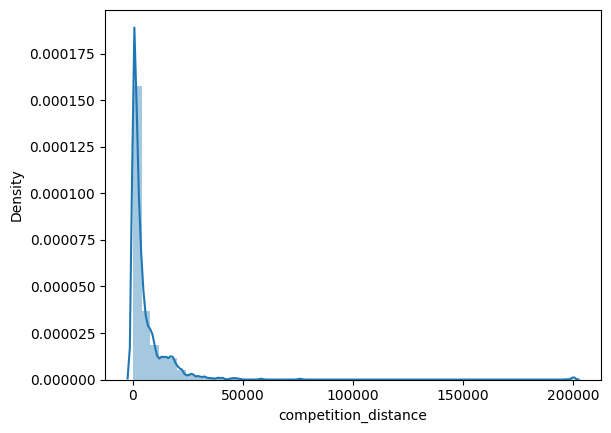

In [13]:
sns.distplot(df1['competition_distance'])

## 1.7.2 Categorical Attributes

In [14]:
# check categorical
cat_attributes.apply(lambda x: x.unique().shape[0])

,0
state_holiday,4
store_type,4
assortment,3
promo_interval,4
month_map,12


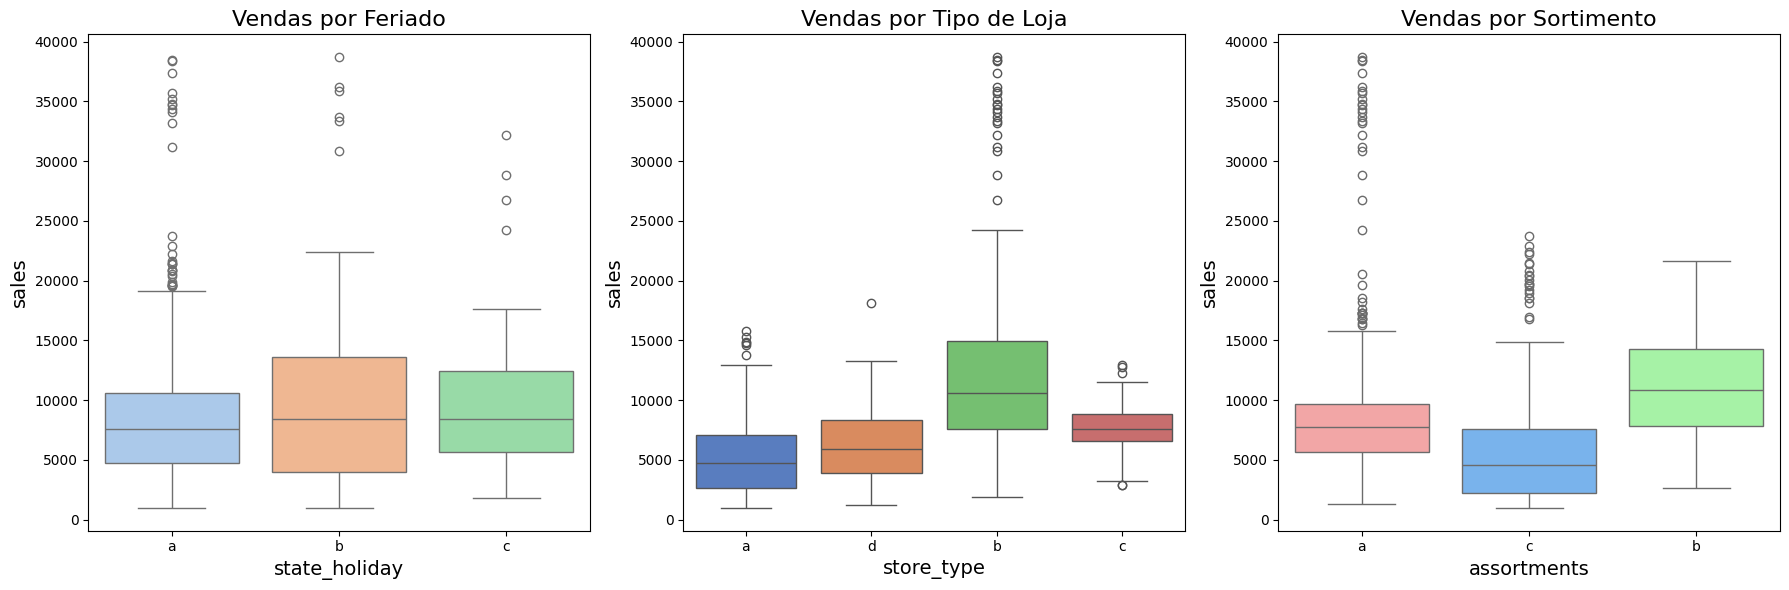

In [15]:
aux1 = df1[(df1['state_holiday'] != '0') & (df1['sales'] > 0)]

plt.figure(figsize=(18, 6))

plt.subplot(1, 3, 1)
sns.boxplot(x='state_holiday', y='sales', data=aux1, hue='state_holiday', palette='pastel', legend=False)
plt.title('Vendas por Feriado', fontsize=16)
plt.xlabel('state_holiday', fontsize=14)
plt.ylabel('sales', fontsize=14)

plt.subplot(1, 3, 2)
sns.boxplot(x='store_type', y='sales', data=aux1, hue='store_type', palette='muted', legend=False)
plt.title('Vendas por Tipo de Loja', fontsize=16)
plt.xlabel('store_type', fontsize=14)
plt.ylabel('sales', fontsize=14)

plt.subplot(1, 3, 3)
sns.boxplot(x='assortment', y='sales', data=aux1, hue='assortment', palette=['#FF9999', '#66B3FF', '#99FF99'], legend=False)
plt.title('Vendas por Sortimento', fontsize=16)
plt.xlabel('assortments', fontsize=14)
plt.ylabel('sales', fontsize=14)

plt.tight_layout()
plt.show()

# 2.0 FEATURES ENGINEERING


In [16]:
df2 = df1.copy()

## 2.1 Mapa Mental de Hipóteses

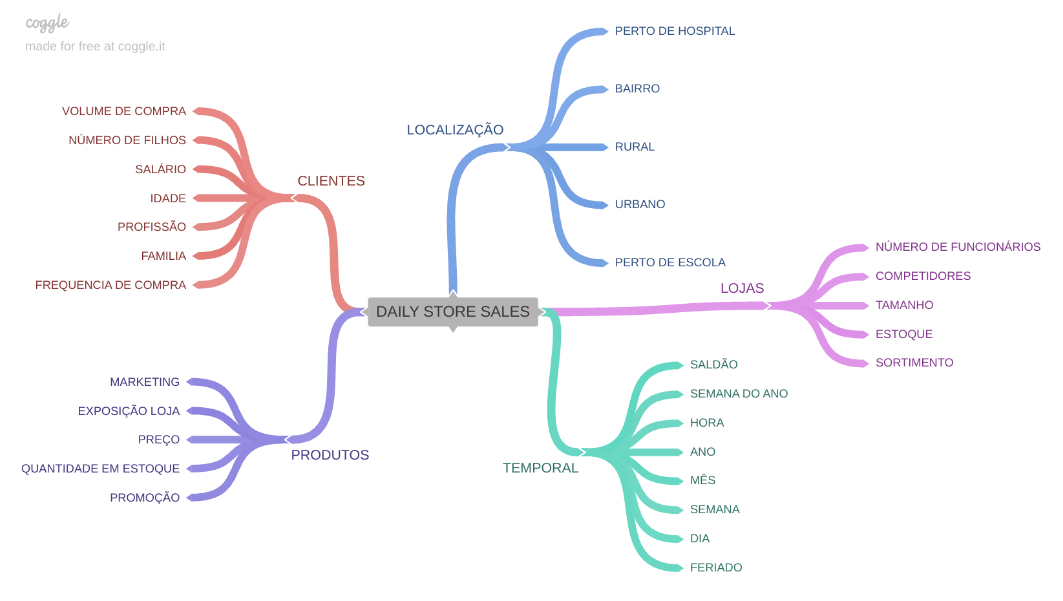

In [17]:
Image('/content/drive/MyDrive/DS em Produção/Image/MindMapHipoteses.png')

## 2.2 Criação de Hipóteses

### 2.2.1 Hipóteses Loja

**1.** Lojas com número maior de funcionários deveriam vender mais.

**2.** Lojas com maior capacidade de estoque deveriam vender mais.

**3.** Lojas com maior porte deveriam vender mais.

**4.** Lojas com maior sortimentos deveriam vender mais.

**5.** Lojas com competidores mais próximos deveriam vender menos.

**6.** Lojas com competidores à mais tempo deveriam vendem mais.


### 2.2.2 Hipóteses Produto

**1.** Lojas que investem mais em Marketing deveriam vender mais.

**2.** Lojas com maior exposição de produto deveriam vender mais.

**3.** Lojas com produtos com preço menor deveriam vender mais.

**5.** Lojas com promoções mais agressivas ( descontos maiores ), deveriam vender mais.

**6.** Lojas com promoções ativas por mais tempo deveriam vender mais.

**7.** Lojas com mais dias de promoção deveriam vender mais.

**8.** Lojas com mais promoções consecutivas deveriam vender mais.

### 2.2.3 Hipóteses Temporais

**1.** Lojas abertas durante o feriado de Natal deveriam vender mais.

**2.** Lojas deveriam vender mais ao longo dos anos.

**3.** Lojas deveriam vender mais no segundo semestre do ano.

**4.** Lojas deveriam vender mais depois do dia 10 de cada mês.

**5.** Lojas deveriam vender menos aos finais de semana.

**6.** Lojas deveriam vender menos durante os feriados escolares.



## 2.3 Lista Final de Hipóteses

**1.** Lojas com maior sortimentos deveriam vender mais.

**2.** Lojas com competidores mais próximos deveriam vender menos.

**3.** Lojas com competidores à mais tempo deveriam vendem mais.

**4.** Lojas com promoções ativas por mais tempo deveriam vender mais.

**5.** Lojas com mais dias de promoção deveriam vender mais.

**7.** Lojas com mais promoções consecutivas deveriam vender mais.

**8.** Lojas abertas durante o feriado de Natal deveriam vender mais.

**9.** Lojas deveriam vender mais ao longo dos anos.

**10.** Lojas deveriam vender mais no segundo semestre do ano.

**11.** Lojas deveriam vender mais depois do dia 10 de cada mês.

**12.** Lojas deveriam vender menos aos finais de semana.

**13.** Lojas deveriam vender menos durante os feriados escolares

## 2.4 Feature Engineering

In [18]:
# year
df2['year'] = df2['date'].dt.year

# month
df2['month'] = df2['date'].dt.month

# day
df2['day'] = df2['date'].dt.day

# week of year
df2['week_of_year'] = df2['date'].dt.isocalendar().week

# year week
df2['year_week'] = df2['date'].dt.strftime('%Y-%W')

# competition since
df2['competition_since'] = df2.apply(lambda x: datetime.datetime(year=x['competition_open_since_year'], month=x['competition_open_since_month'], day=1), axis=1)
df2['competition_time_month'] = ((df2['date'] - df2['competition_since']) / 30).apply(lambda x: x.days).astype(int)

# Verificando e limpando valores inválidos de 'promo2_since_week' e 'promo2_since_year'
df2 = df2[df2['promo2_since_week'].between(1, 53, inclusive="both")]  # Apenas semanas válidas
df2 = df2[df2['promo2_since_year'] > 1900]  # Limitar a anos válidos

# promo_since
df2['promo_since'] = df2.apply(lambda x:
                               (datetime.datetime.strptime(f"{int(x['promo2_since_year'])}-W{int(x['promo2_since_week']):02d}-1", "%Y-W%W-%w")
                                - datetime.timedelta(days=7))
                               if not pd.isnull(x['promo2_since_year']) and not pd.isnull(x['promo2_since_week']) else pd.NaT, axis=1)

# promo_time_week
df2['promo_time_week'] = ((df2['date'] - df2['promo_since']) / 7).apply(lambda x: x.days).astype(int)

# assortment
df2['assortment'] = df2['assortment'].apply(lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended')

# state holiday
df2['state_holiday'] = df2['state_holiday'].apply(lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b' else 'christmas' if x == 'c' else 'regular_day')


# 3.0 FEATURE SELECTION

In [19]:
df3 = df2.copy()

## 3.1 Filtragem das Linhas

In [20]:
df3 = df3[(df3['open'] != '0') & (df3['sales'] > 0)]

## 3.2 Seleção das Colunas

In [21]:
cols_drop = ['customers', 'open', 'promo_interval', 'month_map']
df3 = df3.drop(cols_drop, axis=1)

# 4.0 EXPLORATORY DATA ANALYSIS - E.D.A

In [22]:
df4 = df3.copy()

## 4.1 Análise Univariada

### 4.1.1 Response Variable

<Axes: xlabel='sales'>

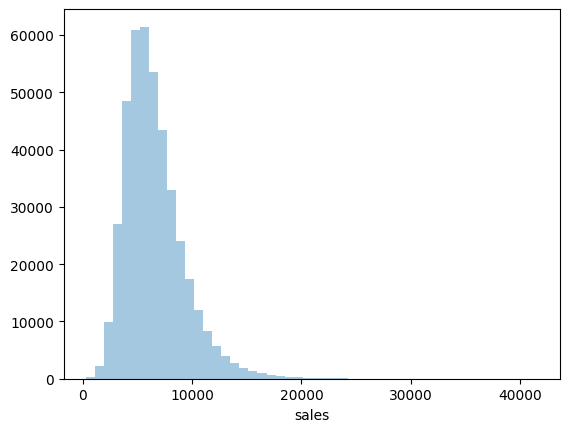

In [23]:
sns.distplot(df4['sales'], kde=False)

### 4.1.2 Numerical Variable

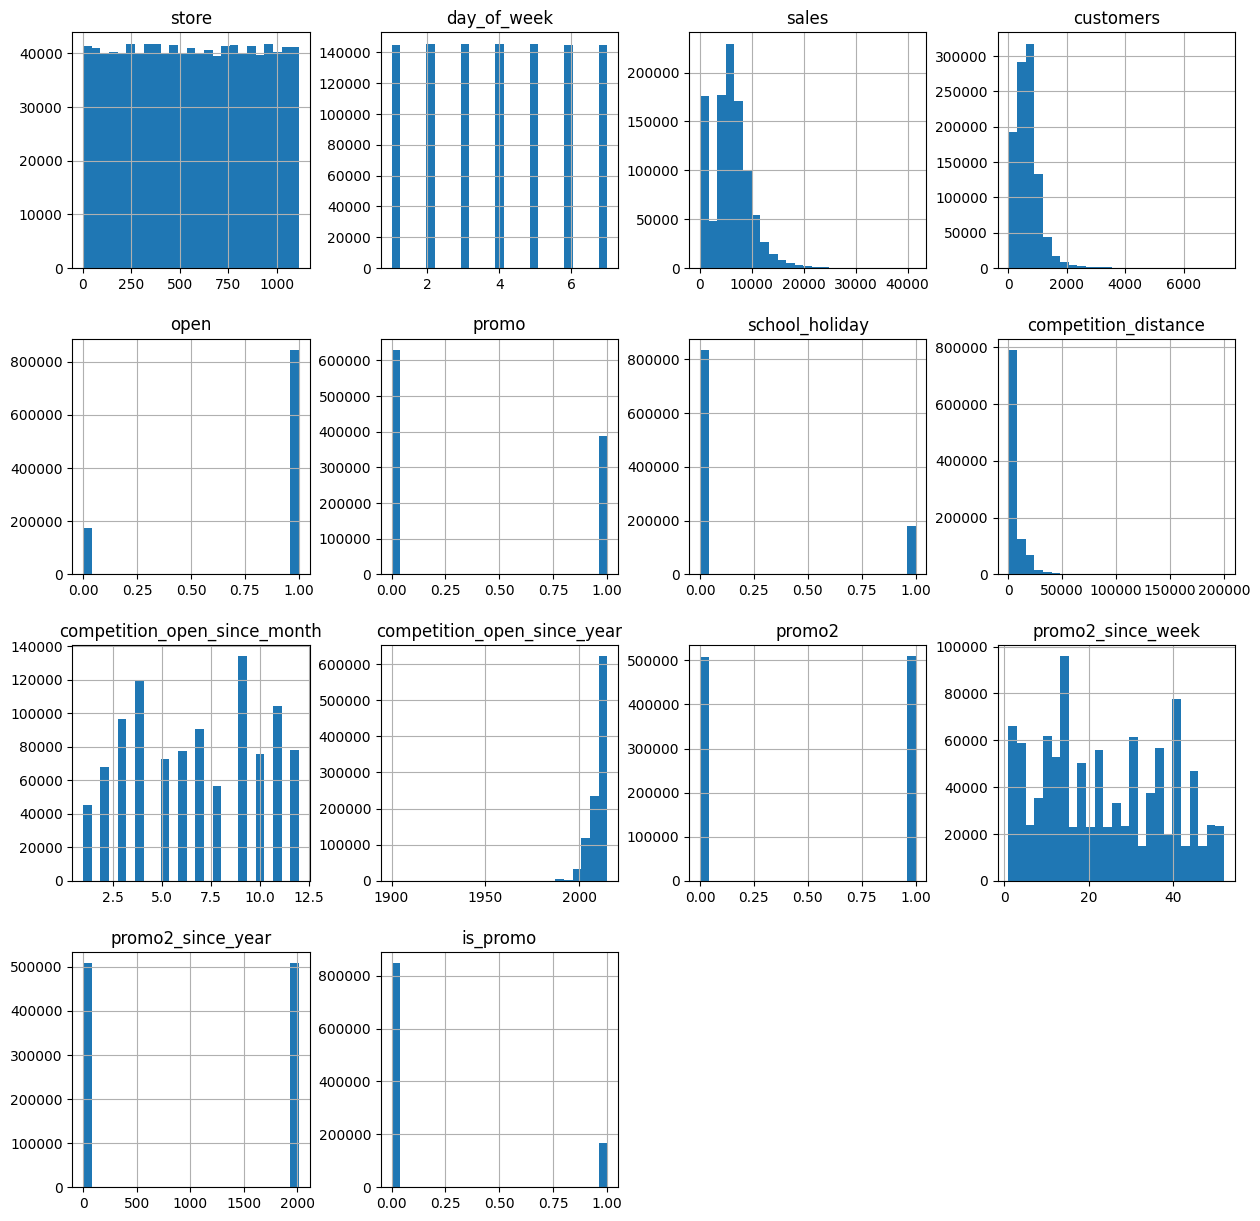

In [24]:
num_attributes.hist(bins=25, figsize=(15, 15))
plt.show()

### 4.1.1 Categorical Variable

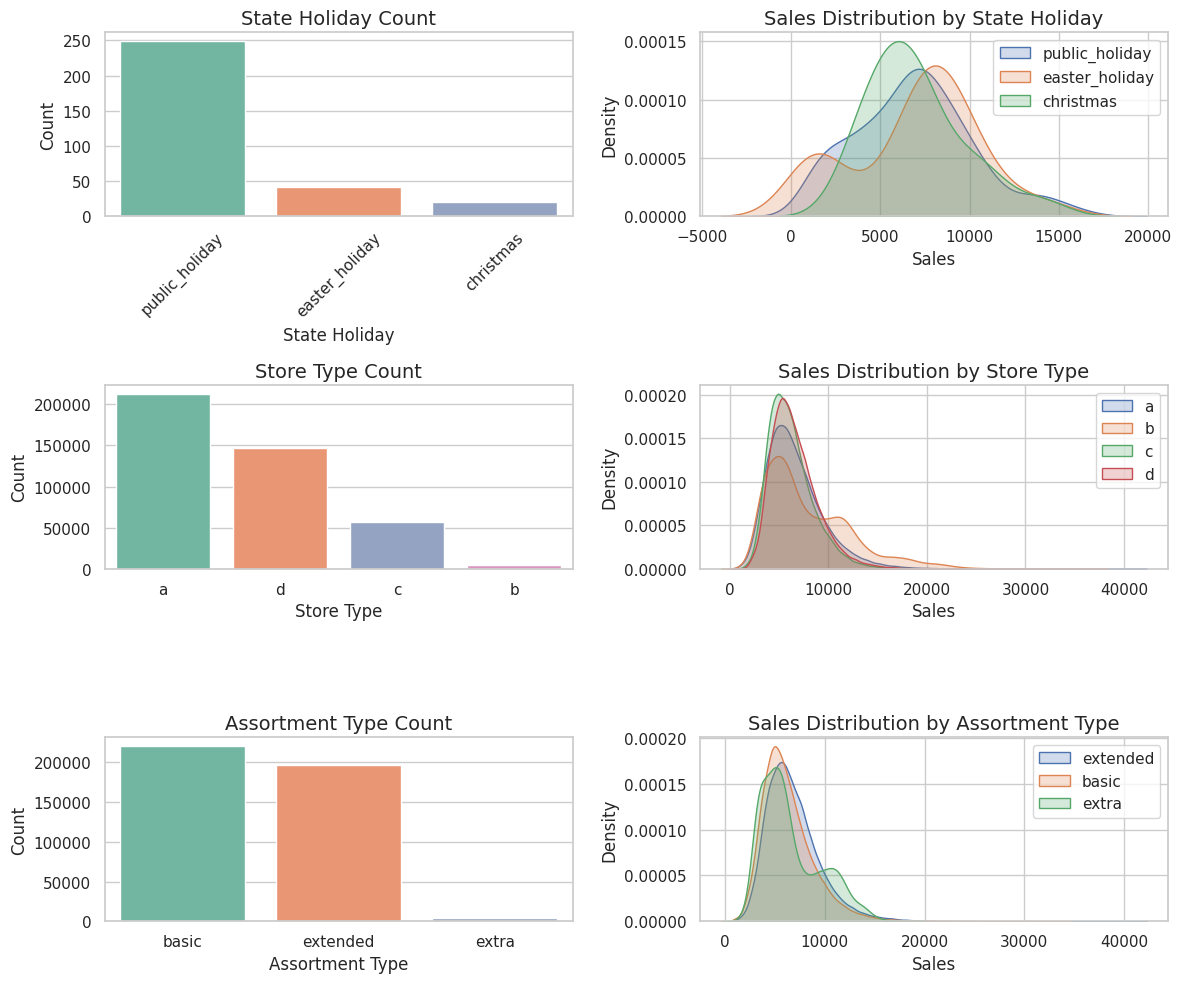

In [25]:
# Define o tamanho da figura e o estilo dos gráficos
plt.figure(figsize=(12, 10))
sns.set(style="whitegrid")

# Gráfico 1: State Holiday (Countplot)
plt.subplot(3, 2, 1)
a = df4[df4['state_holiday'] != 'regular_day']
sns.countplot(x='state_holiday', data=a, palette='Set2')
plt.xticks(rotation=45)
plt.title('State Holiday Count', fontsize=14)
plt.xlabel('State Holiday', fontsize=12)
plt.ylabel('Count', fontsize=12)

# Gráfico 2: KDE Plot de Sales por State Holiday
plt.subplot(3, 2, 2)
sns.kdeplot(df4[df4['state_holiday'] == 'public_holiday']['sales'], label='public_holiday', shade=True)
sns.kdeplot(df4[df4['state_holiday'] == 'easter_holiday']['sales'], label='easter_holiday', shade=True)
sns.kdeplot(df4[df4['state_holiday'] == 'christmas']['sales'], label='christmas', shade=True)
plt.title('Sales Distribution by State Holiday', fontsize=14)
plt.xlabel('Sales', fontsize=12)
plt.legend()

# Gráfico 3: Store Type (Countplot)
plt.subplot(3, 2, 3)
sns.countplot(x='store_type', data=df4, palette='Set2')
plt.title('Store Type Count', fontsize=14)
plt.xlabel('Store Type', fontsize=12)
plt.ylabel('Count', fontsize=12)

# Gráfico 4: KDE Plot de Sales por Store Type
plt.subplot(3, 2, 4)
sns.kdeplot(df4[df4['store_type'] == 'a']['sales'], label='a', shade=True)
sns.kdeplot(df4[df4['store_type'] == 'b']['sales'], label='b', shade=True)
sns.kdeplot(df4[df4['store_type'] == 'c']['sales'], label='c', shade=True)
sns.kdeplot(df4[df4['store_type'] == 'd']['sales'], label='d', shade=True)
plt.title('Sales Distribution by Store Type', fontsize=14)
plt.xlabel('Sales', fontsize=12)
plt.legend()

# Gráfico 5: Assortment (Countplot)
plt.subplot(3, 2, 5)
sns.countplot(x='assortment', data=df4, palette='Set2')
plt.title('Assortment Type Count', fontsize=14)
plt.xlabel('Assortment Type', fontsize=12)
plt.ylabel('Count', fontsize=12)

# Gráfico 6: KDE Plot de Sales por Assortment Type
plt.subplot(3, 2, 6)
sns.kdeplot(df4[df4['assortment'] == 'extended']['sales'], label='extended', shade=True)
sns.kdeplot(df4[df4['assortment'] == 'basic']['sales'], label='basic', shade=True)
sns.kdeplot(df4[df4['assortment'] == 'extra']['sales'], label='extra', shade=True)
plt.title('Sales Distribution by Assortment Type', fontsize=14)
plt.xlabel('Sales', fontsize=12)
plt.legend()


plt.tight_layout()
plt.show()

## 4.2 Análise Bivariada

### **H1.** Lojas com maior sortimentos deveriam vender mais.
R: Falsa, lojas com o maior número de sortimentos tendem a vender menos!

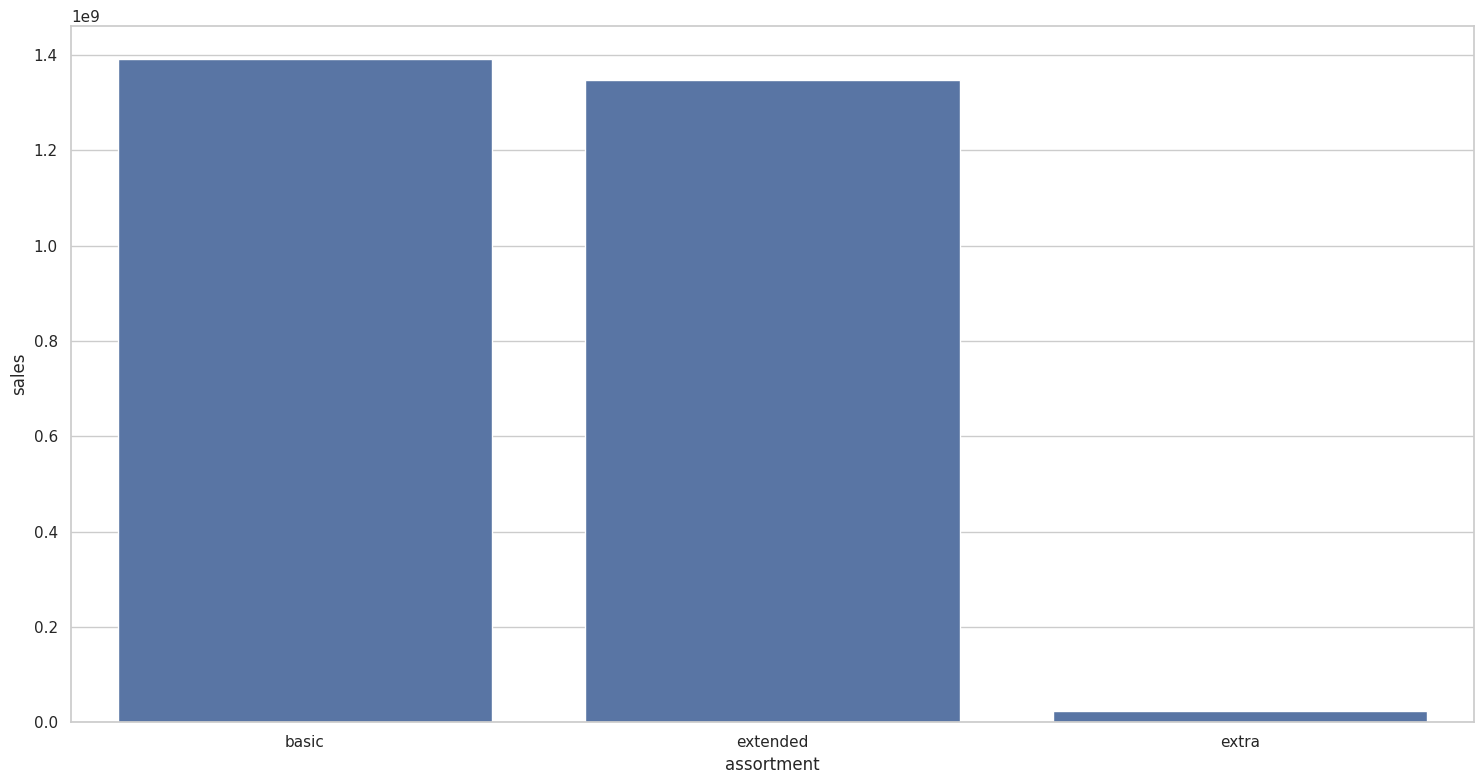

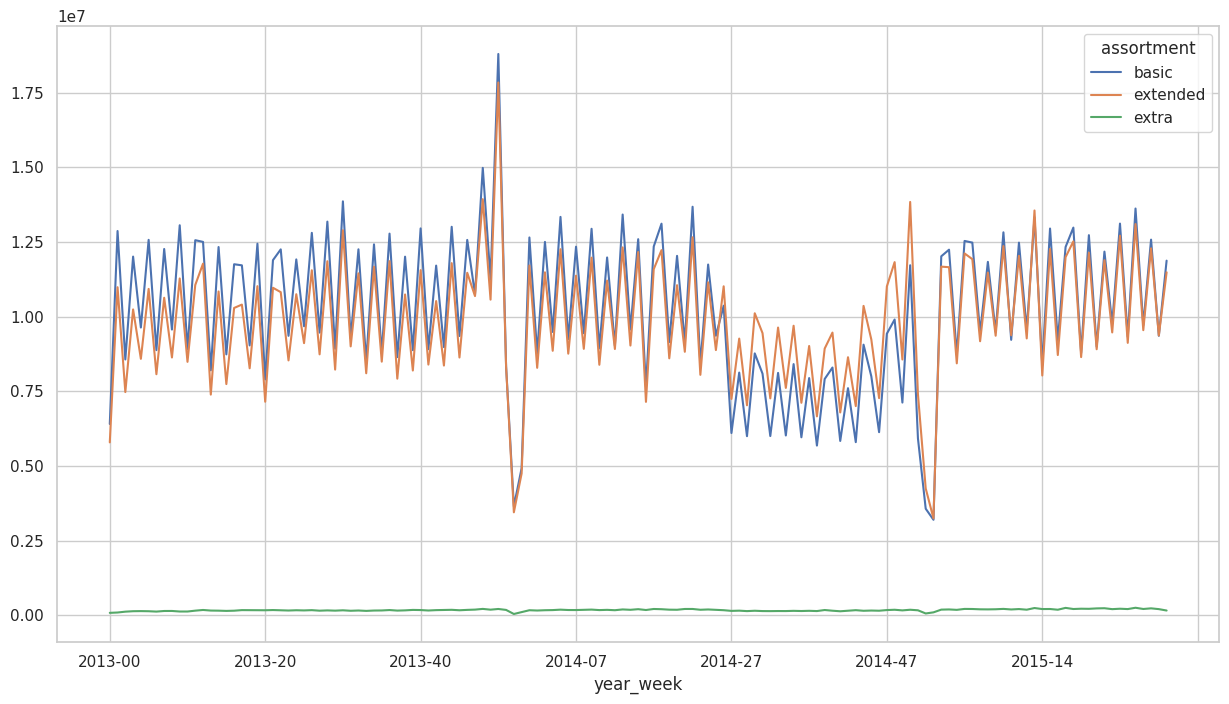

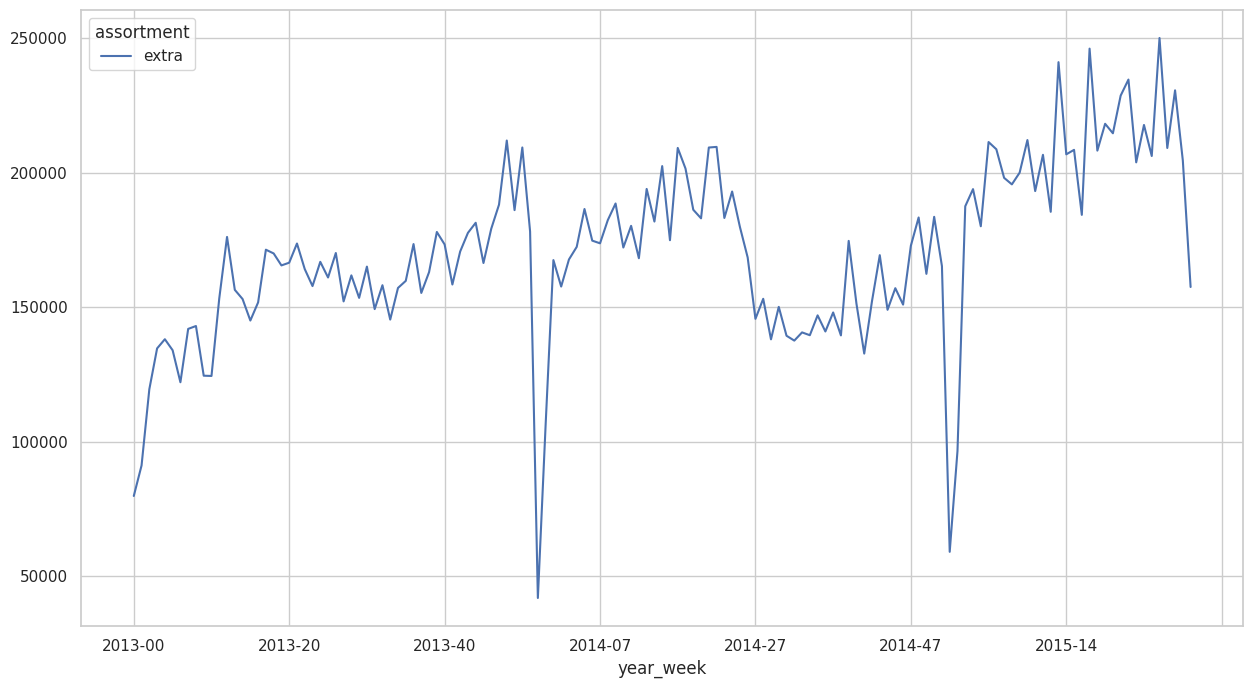

In [108]:
aux1 = df4[['assortment', 'sales']].groupby('assortment').sum().reset_index()
sns.barplot(x='assortment', y='sales', data=aux1)
plt.rcParams['figure.figsize'] = [15, 8];
plt.tight_layout();

aux2 = df4[['year_week', 'assortment', 'sales']].groupby(['year_week', 'assortment']).sum().reset_index()
aux2.pivot(index='year_week', columns='assortment', values='sales').plot()
plt.show()

aux3 = aux2[aux2['assortment'] == 'extra']
aux3.pivot(index='year_week', columns='assortment', values='sales').plot()
plt.show()


### **H2.** Lojas com competidores mais próximos deveriam vender menos.
R: Falso, quanto mais próximos os concorrentes maiores são as vendas.

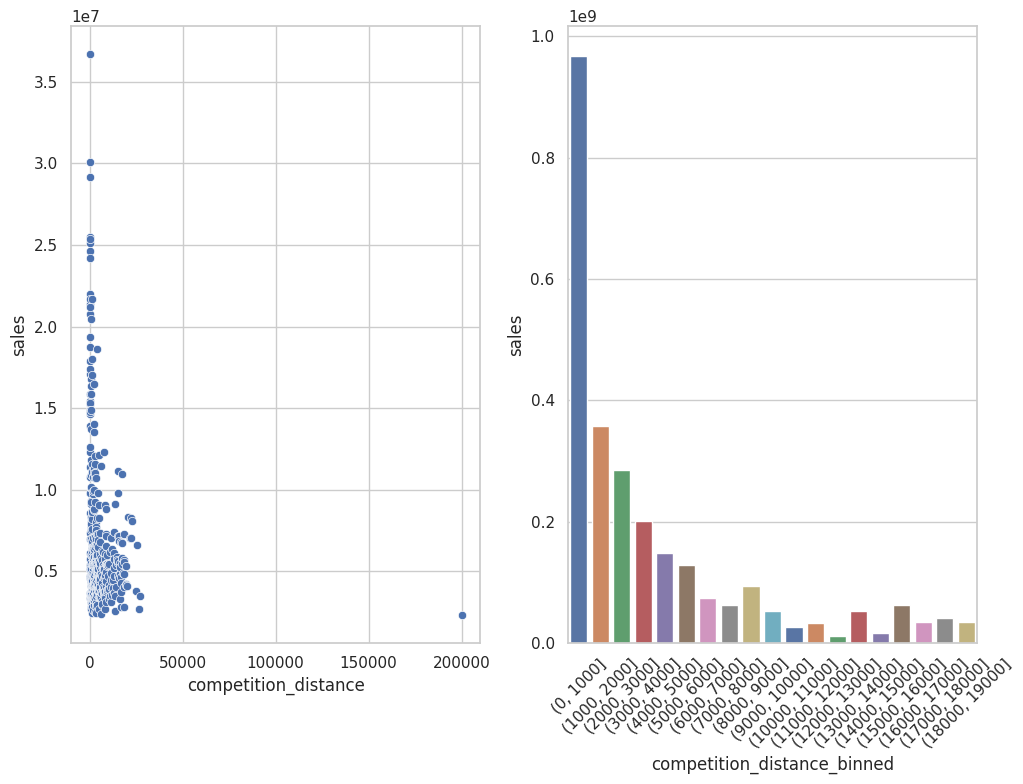

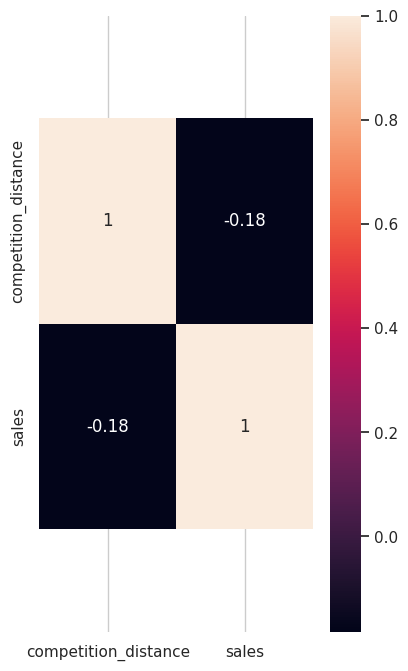

In [107]:
aux1 = df4[['competition_distance', 'sales']].groupby('competition_distance').sum().reset_index()

plt.subplot(1, 3, 1)
sns.scatterplot(x='competition_distance', y='sales', data=aux1);
plt.rcParams['figure.figsize'] = [15, 8];
plt.tight_layout();

plt.subplot(1, 3, 2)
bins = list(np.arange(0, 20000, 1000))
aux1['competition_distance_binned'] = pd.cut(aux1['competition_distance'], bins=bins)
aux2 = aux1[['competition_distance_binned', 'sales']].groupby('competition_distance_binned').sum().reset_index()
sns.barplot(x='competition_distance_binned', y='sales', data=aux2, palette='deep');
plt.xticks(rotation=45);
plt.tight_layout();
plt.show()

corr_data = aux1[['competition_distance', 'sales']]
plt.subplot(1, 3, 3)
x = sns.heatmap(corr_data.corr(method='pearson'), annot=True)
bottom, top = x.get_ylim()  # Corrigido para get_ylim()
x.set_ylim(bottom + 0.5, top - 0.5)
plt.show()

### **H3.** Lojas com competidores à mais tempo deveriam vendem mais.
R: Falsa, lojas com competidores à mais tempo vendem menos.

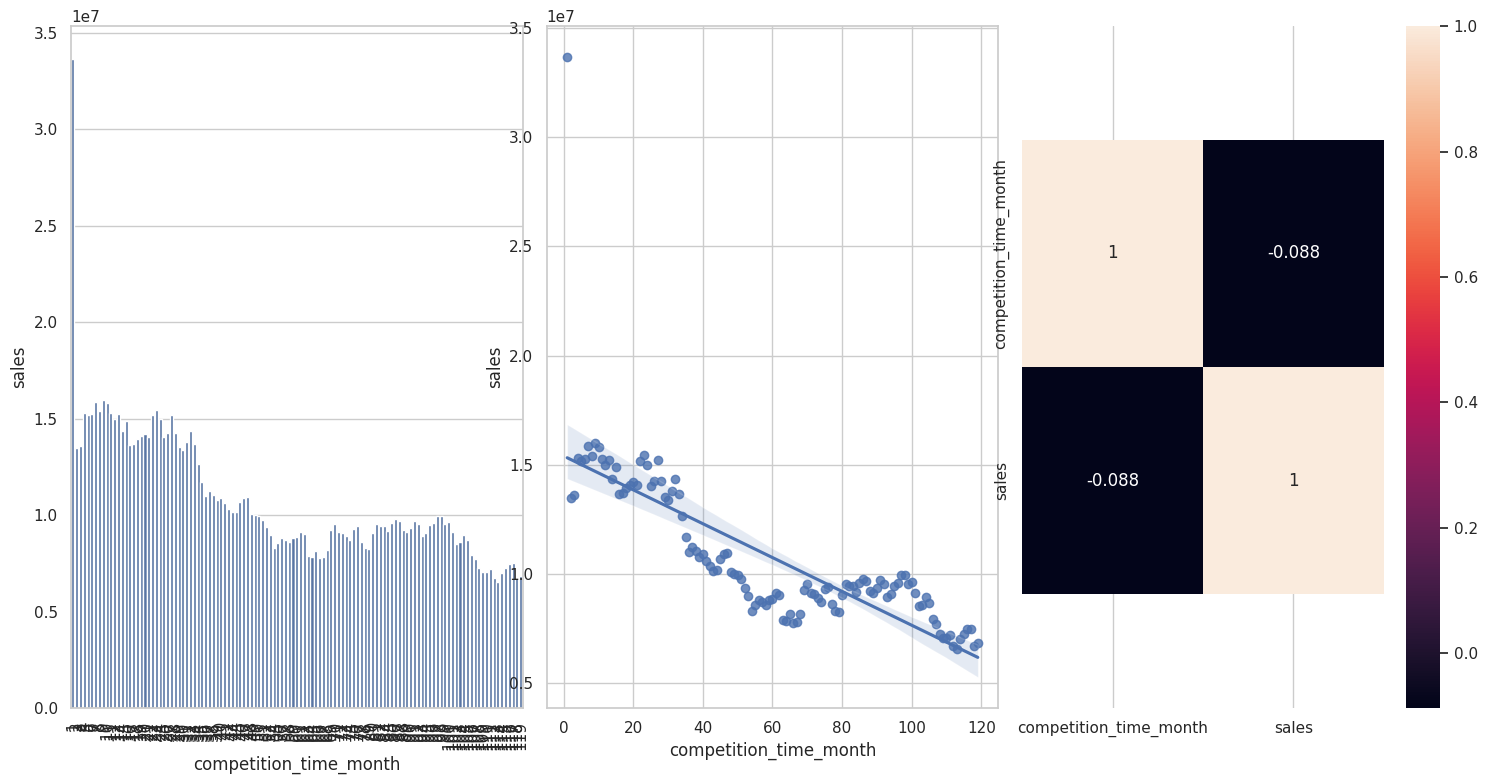

In [94]:
plt.subplot(1, 3, 1)
aux1 = df4[['competition_time_month', 'sales']].groupby('competition_time_month').sum().reset_index()
aux2 = aux1[(aux1['competition_time_month'] < 120) & (aux1['competition_time_month'] > 0)]
sns.barplot(x='competition_time_month', y='sales', data=aux2);
plt.xticks(rotation=90);
plt.rcParams['figure.figsize'] = [15, 8];
plt.tight_layout();

plt.subplot(1, 3, 2)
sns.regplot(x='competition_time_month', y='sales', data=aux2);

plt.subplot(1, 3, 3)
corr_data = aux1[['competition_time_month', 'sales']]
x = sns.heatmap(corr_data.corr(method='pearson'), annot=True)
bottom, top = x.get_ylim()
x.set_ylim(bottom + 0.5, top - 0.5)

plt.show()

### **H4.** Lojas com promoções ativas por mais tempo deveriam vender mais.
R: Falsa, pois lojas com promoções ativas por mais tempo tendem a vender menos !

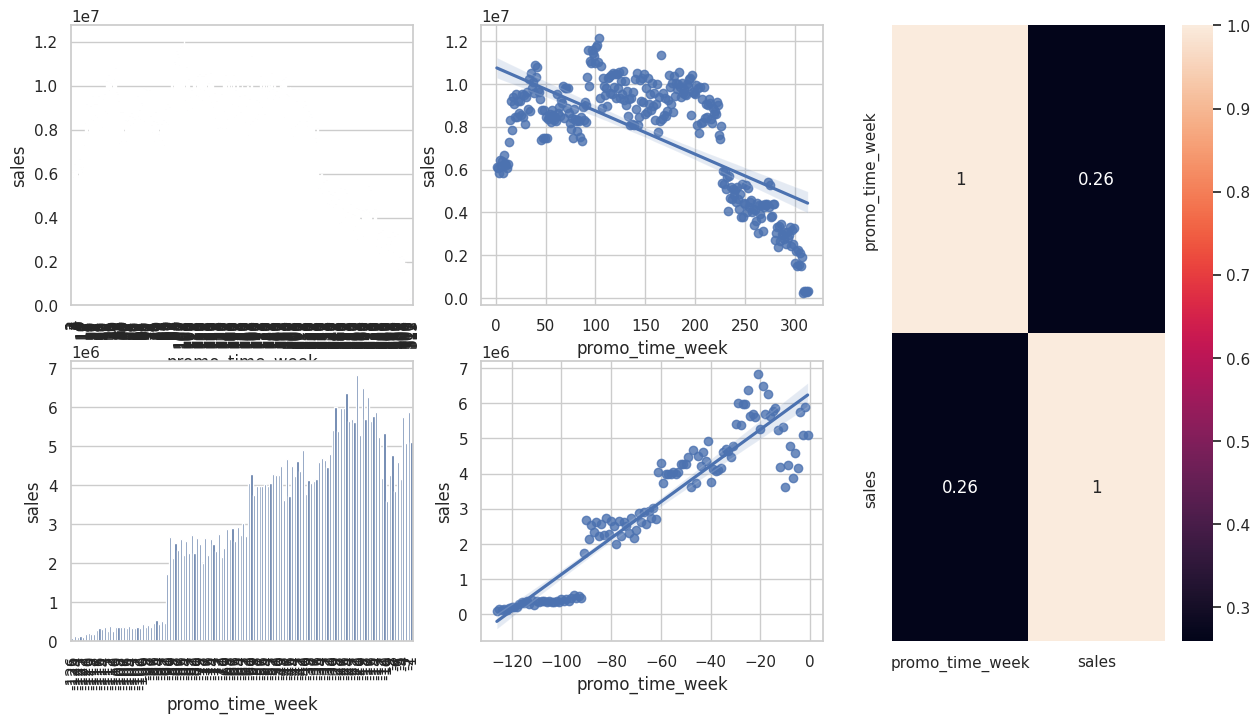

In [86]:
aux1 = df4[['promo_time_week', 'sales']].groupby('promo_time_week').sum().reset_index()

# criando o grid
grid = GridSpec(2, 3)

# selecionando promo extendido
plt.subplot(grid[0,0])
aux2 = aux1[aux1['promo_time_week'] > 0]
sns.barplot(x='promo_time_week', y='sales', data=aux2, palette = 'deep');
plt.xticks(rotation=90);
plt.rcParams['figure.figsize'] = [18, 10];

plt.subplot(grid[0,1])
sns.regplot(x='promo_time_week', y='sales', data=aux2);

# selecionando promo regular
plt.subplot(grid[1,0])
aux3 = aux1[aux1['promo_time_week'] < 0]
sns.barplot(x='promo_time_week', y='sales', data=aux3);
plt.xticks(rotation=90);

plt.subplot(grid[1,1])
sns.regplot(x='promo_time_week', y='sales', data=aux3);

plt.subplot(grid[:,2])
corr_data = aux1[['promo_time_week', 'sales']]
x = sns.heatmap(corr_data.corr(method='pearson'), annot=True)

### **H7.** Lojas com mais promoções consecutivas deveriam vender mais.
R: Falsa, lojas com mais promoções consecutivas vendem menos !

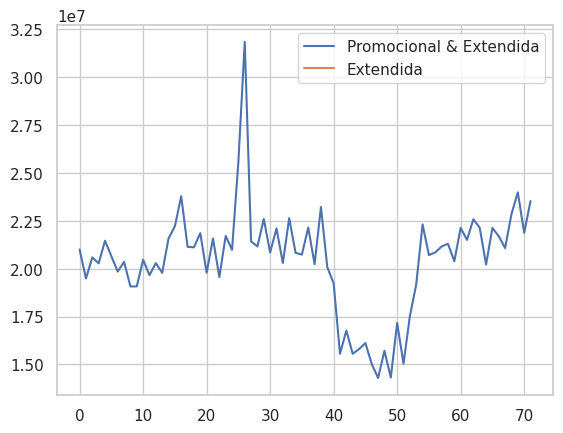

In [30]:
aux1 = df4[(df4['promo'] == 1) & (df4['promo2'] == 1)][['year_week', 'sales']].groupby('year_week').sum().reset_index()
ax = aux1.plot()

aux2 = df4[(df4['promo'] == 1) & (df4['promo2'] == 0)][['year_week', 'sales']].groupby('year_week').sum().reset_index()
aux2.plot(ax=ax)

ax.legend(labels=['Promocional & Extendida', 'Extendida']);

### **H8.** Lojas abertas durante o feriado de Natal deveriam vender mais.
R: Falso, lojas abertas durante o Natal vendem menos comparados aos outros feriados.

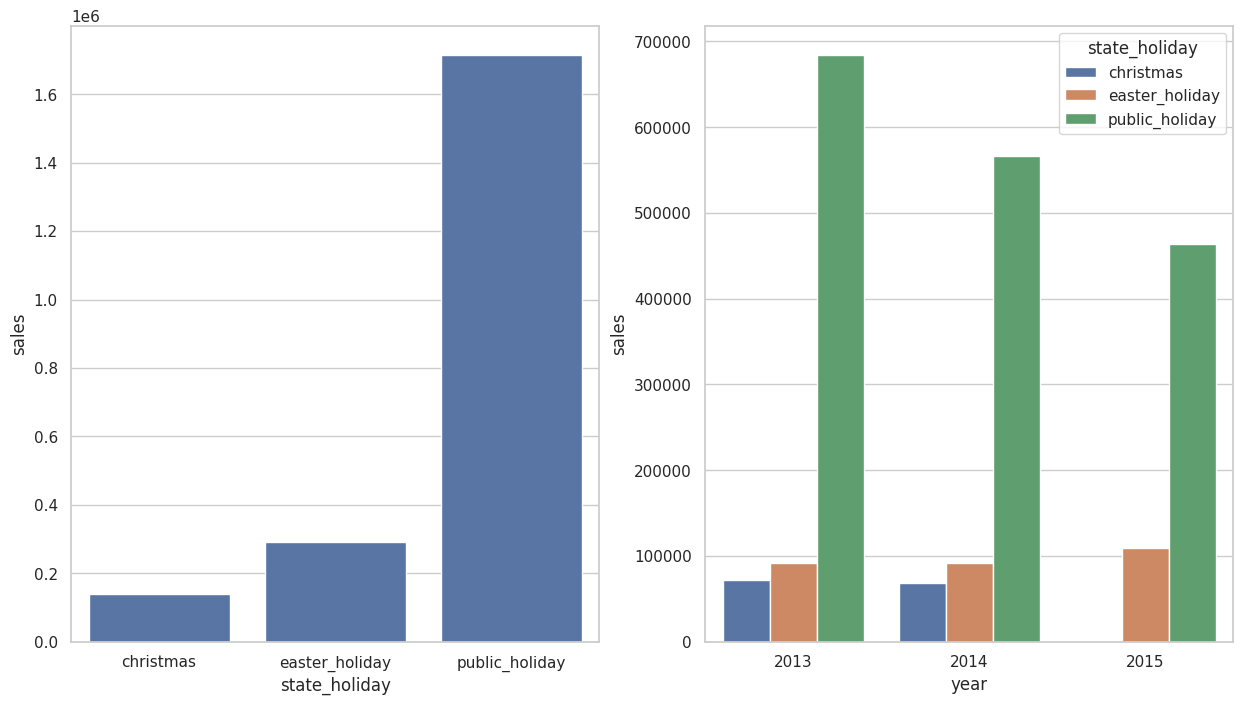

In [83]:
aux = df4[df4['state_holiday'] != 'regular_day']

plt.subplot(1, 2, 1)
aux1 = aux[['state_holiday', 'sales']].groupby('state_holiday').sum().reset_index()
sns.barplot(x='state_holiday', y='sales', data=aux1);
plt.rcParams['figure.figsize'] = [15, 8];

plt.subplot(1, 2, 2)
aux2 = aux[['year', 'state_holiday', 'sales']].groupby(['year', 'state_holiday']).sum().reset_index()
sns.barplot(x='year', y='sales', hue='state_holiday', data=aux2);

### **H9.** Lojas deveriam vender mais ao longo dos anos.
R: Falsa, as lojas estão vendendo menos ao longo dos anos



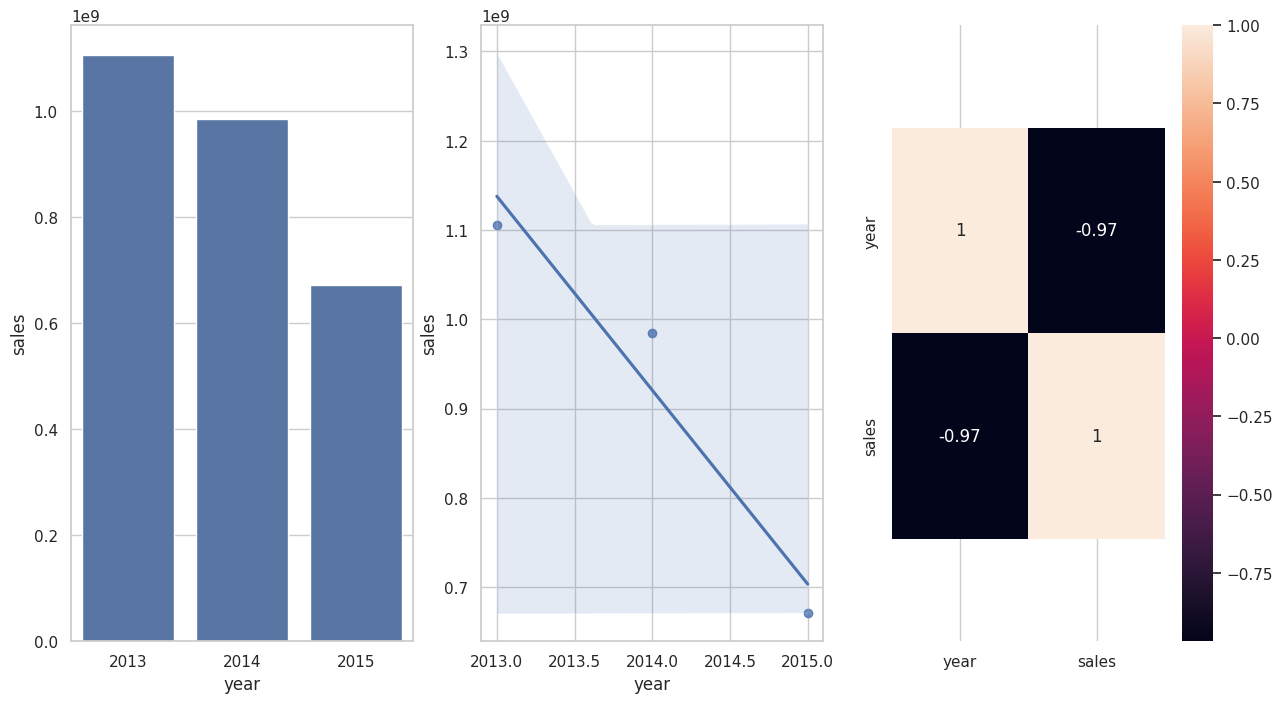

In [82]:
plt.subplot(1, 3, 1)
aux1 = df4[['year', 'sales']].groupby('year').sum().reset_index()
sns.barplot(x='year', y='sales', data=aux1);
plt.rcParams['figure.figsize'] = [15, 8];

plt.subplot(1, 3, 2)
sns.regplot(x='year', y='sales', data=aux1);

plt.subplot(1, 3, 3)
corr_data = aux1[['year', 'sales']]
x = sns.heatmap(corr_data.corr(method='pearson'), annot=True)
bottom, top = x.get_ylim()
x.set_ylim(bottom + 0.5, top - 0.5)
plt.show()

### **H10.** Lojas deveriam vender mais no segundo semestre do ano.
R: Falso, as lojas vendem menos após os 6 primeiros meses

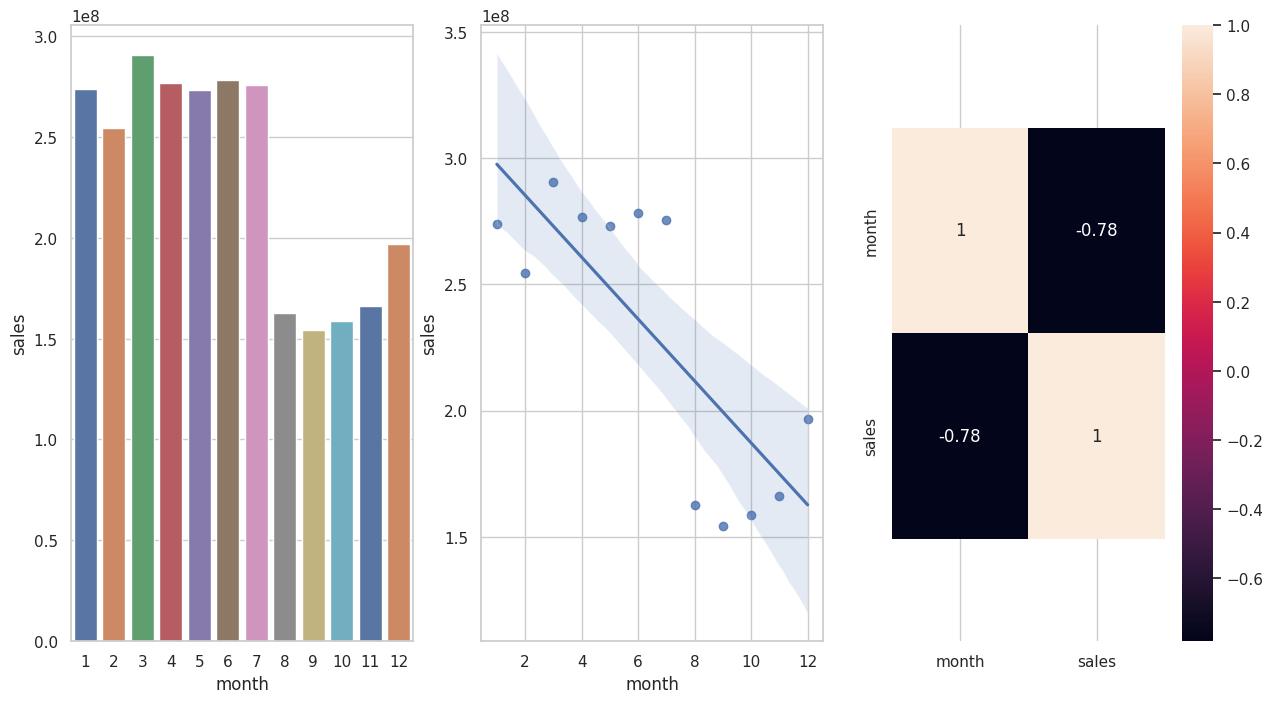

In [81]:
aux1 = df4[['month', 'sales']].groupby('month').sum().reset_index()

plt.subplot(1, 3, 1)
sns.barplot(x='month', y='sales', data=aux1, palette = 'deep');
plt.rcParams['figure.figsize'] = [15, 8];


plt.subplot(1, 3, 2)
sns.regplot(x='month', y='sales', data=aux1);

plt.subplot(1, 3, 3)
corr_data = aux1[['month', 'sales']]
x = sns.heatmap(corr_data.corr(method='pearson'), annot=True);
bottom, top = x.get_ylim()
x.set_ylim(bottom + 0.5, top - 0.5)
plt.show()

### **H11.** Lojas deveriam vender mais depois do dia 10 de cada mês.
R: Verdadeira, lojas vendem mais após o dia 10 de cada mês.

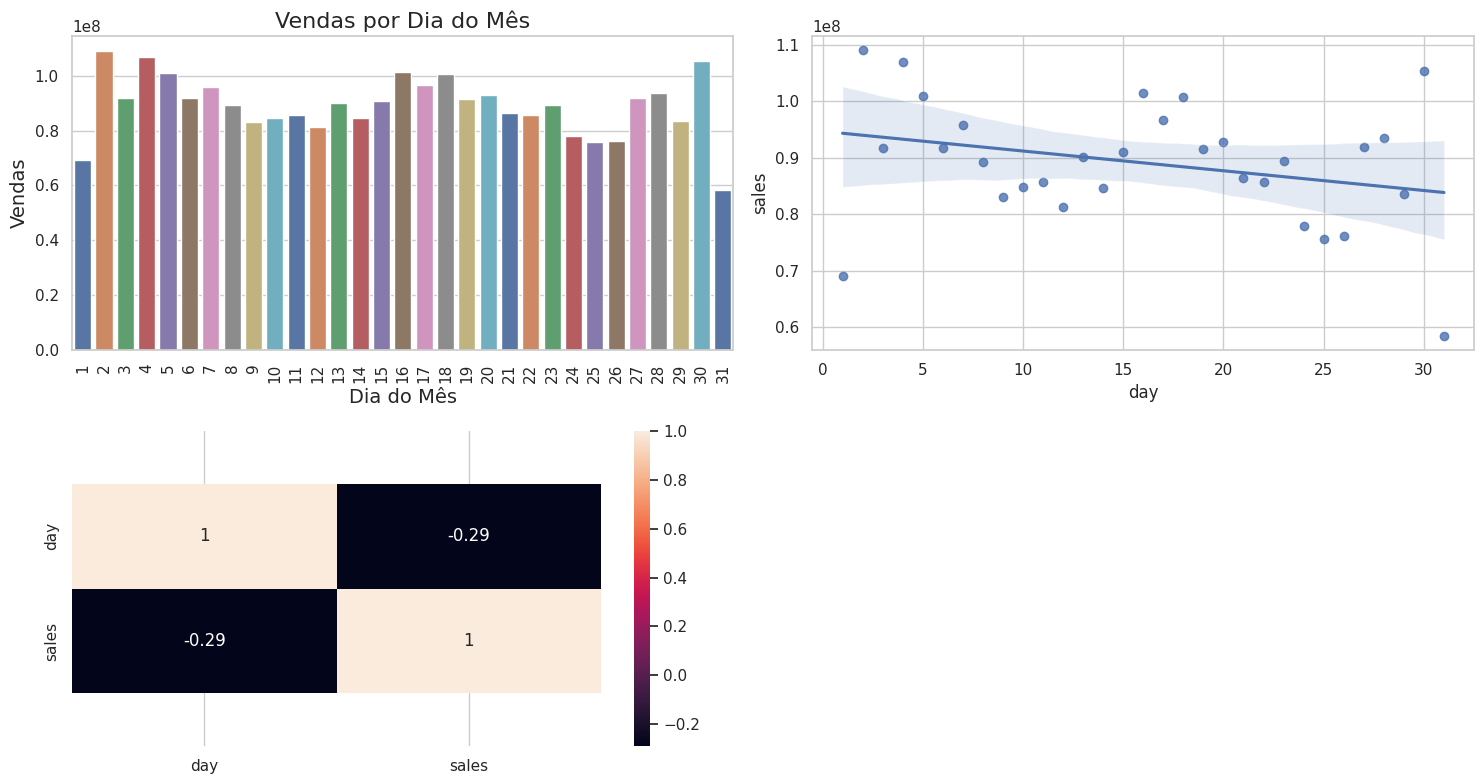

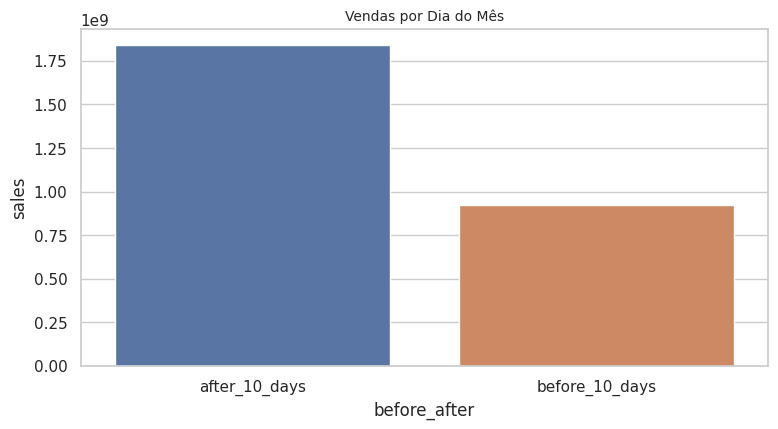

In [73]:
aux1 = df4[['day', 'sales']].groupby('day').sum().reset_index()

plt.subplot(2, 2, 1)
sns.barplot(x='day', y='sales', data=aux1, palette='deep');
plt.rcParams['figure.figsize'] = [15, 8];
plt.title('Vendas por Dia do Mês', fontsize=16);
plt.xlabel('Dia do Mês', fontsize=14);
plt.ylabel('Vendas', fontsize=14);
plt.xticks(rotation=90);
plt.tight_layout();

plt.subplot(2, 2, 2)
sns.regplot(x='day', y='sales', data=aux1);
plt.tight_layout();

plt.subplot(2, 2, 3)
corr_data = aux1[['day', 'sales']];
x = sns.heatmap(corr_data.corr(method='pearson'), annot=True)
bottom, top = x.get_ylim();
x.set_ylim(bottom + 0.5, top - 0.5);
plt.tight_layout();
plt.show();


plt.subplot(2, 2, 4)
aux1['before_after'] = aux1['day'].apply(lambda x: 'before_10_days' if x <= 10 else 'after_10_days');
df4['before_after'] = df4['day'].apply(lambda x: 'before_10_days' if x <= 10 else 'after_10_days');
aux2 = aux1[['before_after', 'sales']].groupby('before_after').sum().reset_index();
sns.barplot(x='before_after', y='sales', data=aux2, palette='deep');
plt.title('Vendas por Dia do Mês', fontsize=10);
plt.tight_layout();




### **H12.** Lojas deveriam vender menos aos finais de semana.
R: Verdadeira, lojas vendem menos aos finais de semana!

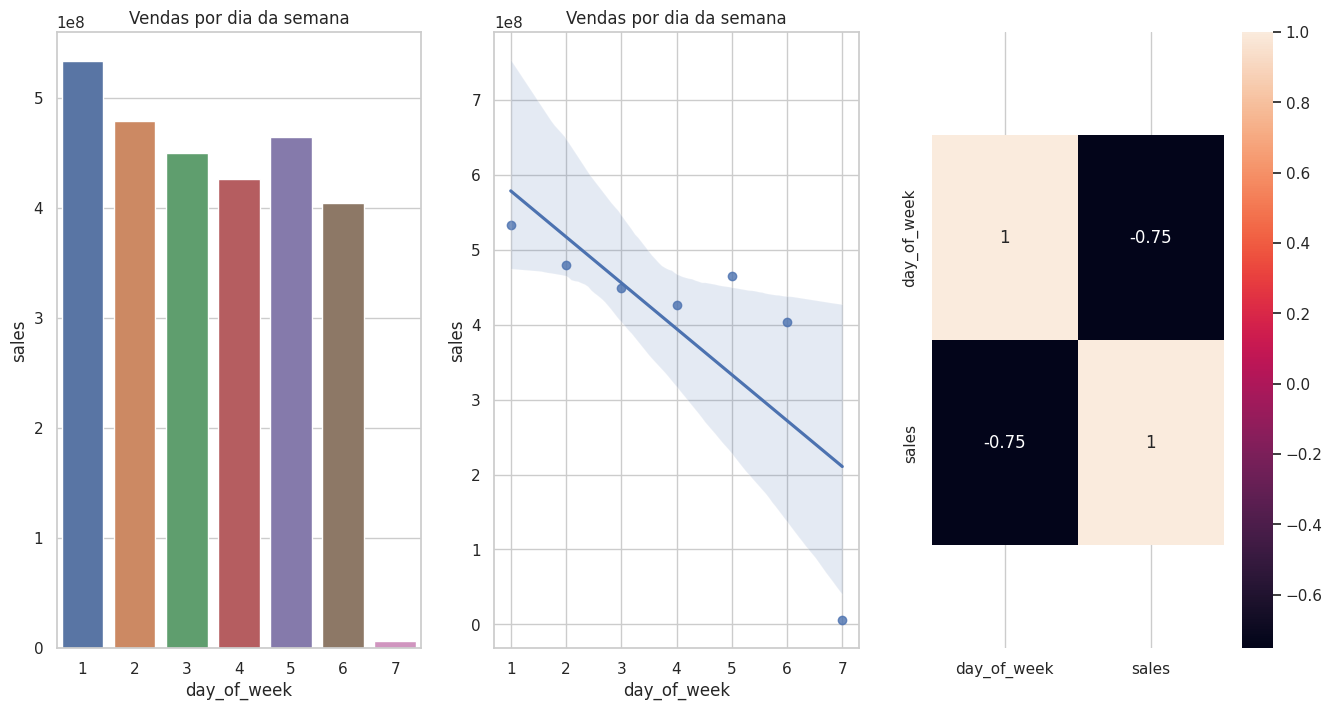

In [54]:
aux1 = df4[['day_of_week', 'sales']].groupby('day_of_week').sum().reset_index()

plt.subplot(1, 3, 1)
sns.barplot(x='day_of_week', y='sales', data=aux1, palette='deep');
plt.title('Vendas por dia da semana');

plt.subplot(1, 3, 2)
sns.regplot(x='day_of_week', y='sales', data=aux1);
plt.title('Vendas por dia da semana');

plt.subplot(1, 3, 3)
corr_data = aux1[['day_of_week', 'sales']]
x = sns.heatmap(corr_data.corr(method='pearson'), annot=True)
bottom, top = x.get_ylim()
x.set_ylim(bottom + 0.5, top - 0.5)
plt.show()

### **13.** Lojas deveriam vender menos durante os feriados escolares
R: Verdadeira, lojas vendem menos durante os feriados escolares, exceto aos meses de Julho e Agosto.

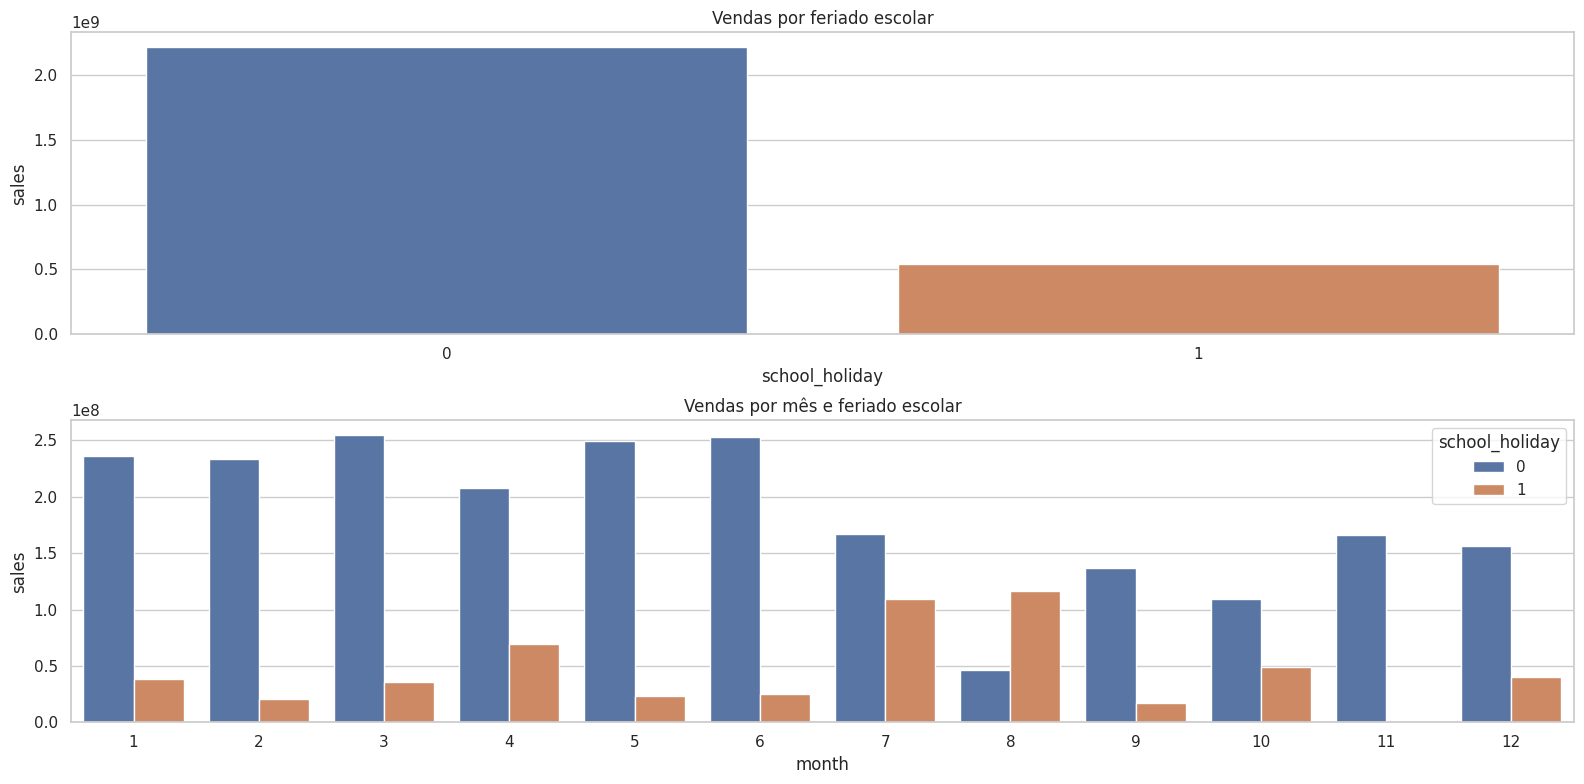

In [60]:
aux1 = df4[['school_holiday', 'sales']].groupby('school_holiday').sum().reset_index()

plt.subplot(2, 1, 1)
sns.barplot(x='school_holiday', y='sales', data=aux1, palette='deep');
plt.title('Vendas por feriado escolar');

plt.subplot(2, 1, 2)
aux2 = df4[['month', 'school_holiday', 'sales']].groupby(['month', 'school_holiday']).sum().reset_index()
sns.barplot(x='month', y='sales', hue='school_holiday', data=aux2, palette='deep');
plt.tight_layout()
plt.title('Vendas por mês e feriado escolar');



## 4.2.2 Resumo de Hipoteses

In [112]:
# criação da tabela

tab = [['Hipóteses', 'Conclusão', 'Relevância'],
       ['H1', 'Falsa', 'Baixa'],
       ['H2', 'Falsa', 'Média'],
       ['H3', 'Falsa', 'Média'],
       ['H4', 'Falsa', 'Baixa'],
       ['H5','-','-'],
       ['H7', 'Falsa', 'Baixa'],
       ['H8', 'Falsa', 'Média'],
       ['H9', 'Falsa', 'Alta'],
       ['H10', 'Falsa', 'Alta'],
       ['H11', 'Verdadeira', 'Alta'],
       ['H12', 'Verdadeira', 'Alta'],
       ['H13', 'Verdadeira', 'Baixa']]

print(tabulate(tab, headers='firstrow'))

Hipóteses    Conclusão    Relevância
-----------  -----------  ------------
H1           Falsa        Baixa
H2           Falsa        Média
H3           Falsa        Média
H4           Falsa        Baixa
H5           -            -
H7           Falsa        Baixa
H8           Falsa        Média
H9           Falsa        Alta
H10          Falsa        Alta
H11          Verdadeira   Alta
H12          Verdadeira   Alta
H13          Verdadeira   Baixa


## 4.3 Análise Multivariada

### 4.3.1 Numerical Attributes

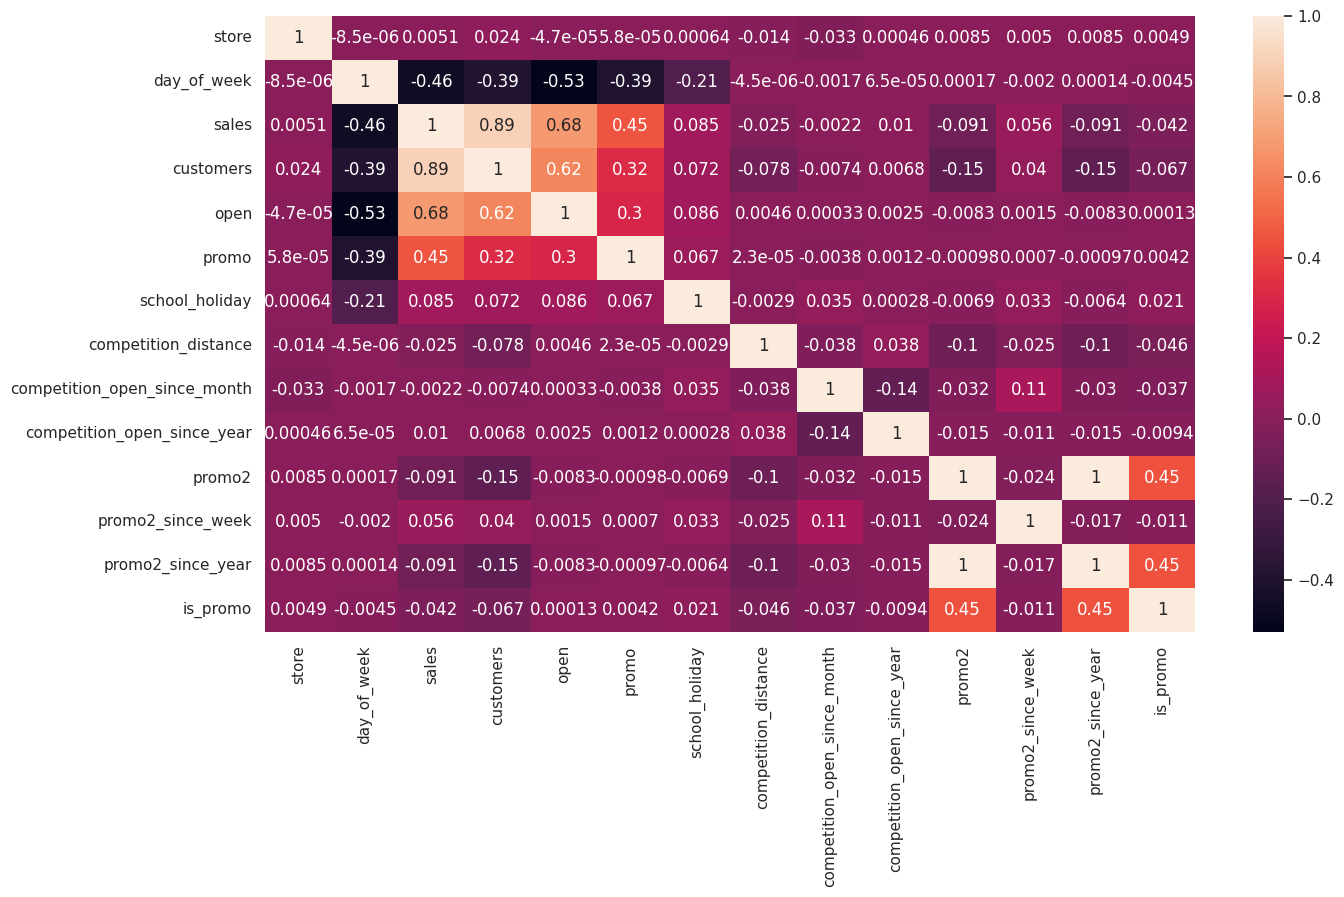

In [116]:
correlation = num_attributes.corr(method='pearson')
sns.heatmap(correlation, annot=True);


### 4.3.2 Categorical Attributes

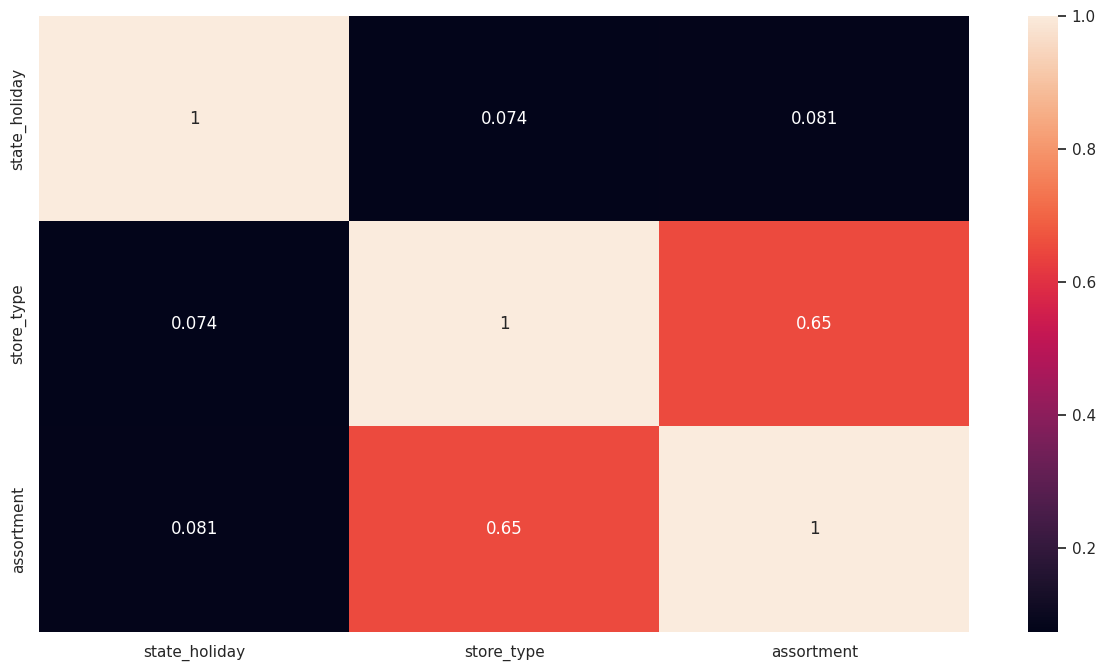

In [130]:
# Selecionando apenas os Dados Categoricos - Only Categorical Datas

a = df4.select_dtypes(include='object')

# Calculando o Cramer_V dos Objetos - Calculate Cramer_V

a1 = cramer_v(a['state_holiday'], a['state_holiday'])
a2 = cramer_v(a['state_holiday'], a['store_type'])
a3 = cramer_v(a['state_holiday'], a['assortment'])

a4 = cramer_v(a['store_type'], a['state_holiday'])
a5 = cramer_v(a['store_type'], a['store_type'])
a6 = cramer_v(a['store_type'], a['assortment'])

a7 = cramer_v(a['assortment'], a['state_holiday'])
a8 = cramer_v(a['assortment'], a['store_type'])
a9 = cramer_v(a['assortment'], a['assortment'])

# Criação da Tabela Final - Final Dataset

d = pd.DataFrame({'state_holiday': [a1, a2, a3],
                  'store_type': [a4, a5, a6],
                  'assortment': [a7, a8, a9]})

d = d.set_index(d.columns)

# Visualização da Correlação através do Heatmap - Visualization of Correlation through Heatmap

sns.heatmap(d, annot=True);

# 5.0 DATA PREPARATION

In [131]:
df5 = df4.copy()

## 5.1 Normalização

## 5.2 Rescaling

In [134]:
a = df5.select_dtypes(include=['int64', 'float64'])

In [136]:
rs = RobustScaler()
mms = MinMaxScaler()

# competition distance
df5['competition_distance'] = rs.fit_transform(df5[['competition_distance']].values)

# competition time month
df5['competition_time_month'] = rs.fit_transform(df5[['competition_time_month']].values)

# promo time week
df5['promo_time_week'] = mms.fit_transform(df5[['promo_time_week']].values)

# year
df5['year'] = mms.fit_transform(df5[['year']].values)


## 5.3 Transformação

### 5.3.1 Encoding

In [138]:
# state holiday - One Hot Encoding
df5 = pd.get_dummies(df5, prefix=['state_holiday'], columns=['state_holiday'])

# store type
le = LabelEncoder()
df5['store_type'] = le.fit_transform(df5['store_type'])

# assortment - Ordinal Encoding
assortment_dict = {'basic': 1, 'extra': 2, 'extended': 3}
df5['assortment'] = df5['assortment'].map(assortment_dict)

### 5.3.2 Response Variable Transformation

In [139]:
df5['sales'] = np.log1p(df5['sales'])

### 5.3.3 Nature Transformation

In [140]:
# day of week
df5['day_of_week_sin'] = df5['day_of_week'].apply(lambda x: np.sin(x * (2. * np.pi/7)))
df5['day_of_week_cos'] = df5['day_of_week'].apply(lambda x: np.cos(x * (2. * np.pi/7)))

# month
df5['month_sin'] = df5['month'].apply(lambda x: np.sin(x * (2. * np.pi/12)))
df5['month_cos'] = df5['month'].apply(lambda x: np.cos(x * (2. * np.pi/12)))

# day
df5['day_sin'] = df5['day'].apply(lambda x: np.sin(x * (2. * np.pi/30)))
df5['day_cos'] = df5['day'].apply(lambda x: np.cos(x * (2. * np.pi/30)))

# week of year
df5['week_of_year_sin'] = df5['week_of_year'].apply(lambda x: np.sin(x * (2. * np.pi/52)))
df5['week_of_year_cos'] = df5['week_of_year'].apply(lambda x: np.cos(x * (2. * np.pi/52)))
